# Projet HESTONNET - CALIBRATION QUASI-INSTANTANÉE DU MODÈLE DE HESTON

Importations 

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from keras.layers import Dense, Input, BatchNormalization, Dropout
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from scipy.optimize import brentq, minimize
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from tqdm.notebook import tqdm
import tensorflow_probability as tfp
from py_vollib_vectorized import vectorized_implied_volatility as implied_vol
import time
import joblib
import warnings
import math
from keras.layers import Input, Dense, BatchNormalization, Dropout, Activation, Concatenate
from keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Configuration pour des résultats reproductibles
tf.random.set_seed(42)
np.random.seed(42)

Génération d'échantillons valides:   0%|          | 0/5000 [00:00<?, ?it/s]


Dataset généré avec succès. Nombre d'échantillons valides : 5000
Shape de X_calib (surfaces de vol): (5000, 150)
Shape de y_calib (paramètres Heston): (5000, 5)


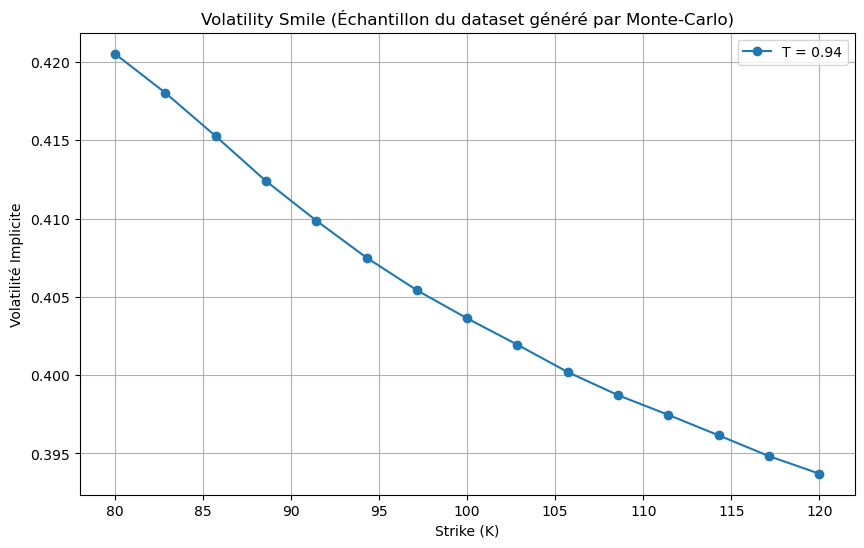

In [39]:
# ===================================================================
# GÉNÉRATION DU DATASET VIA SIMULATION MONTE-CARLO
# ===================================================================


# --- Pricer Heston par Monte-Carlo ---
def heston_mc_pricer(S0, K, T, r, v0, kappa, theta, gamma, rho, M=2500, N=252):
    """
    Calcule les prix d'options pour un ensemble de strikes K en utilisant une seule simulation de Monte-Carlo.
    M: Nombre de simulations (chemins)
    N: Nombre de pas de temps
    """
    # Simulation des chemins
    dt = T/N
    mu = np.array([0,0])
    cov = np.array([[1, rho], [rho, 1]])
    
    S = np.full(shape=(N + 1, M), fill_value=S0)
    v = np.full(shape=(N + 1, M), fill_value=v0)
    
    Z = np.random.multivariate_normal(mu, cov, (N, M))
    
    for i in range(1, N + 1):
        S[i] = S[i-1] * np.exp((r - 0.5 * v[i-1]) * dt + np.sqrt(v[i-1] * dt) * Z[i-1, :, 0])
        v[i] = np.maximum(v[i-1] + kappa * (theta - v[i-1]) * dt + gamma * np.sqrt(v[i-1] * dt) * Z[i-1, :, 1], 0)
    
    # Prix finaux simulés
    final_prices = S[-1]
    
    # Calcul des prix des calls pour chaque strike
    call_prices = np.zeros_like(K, dtype=float)
    for i, k_strike in enumerate(K):
        payoff = np.maximum(final_prices - k_strike, 0)
        call_prices[i] = np.mean(payoff) * np.exp(-r * T)
        
    return call_prices

# --- Génération de données  ---
def generate_calibration_data_mc(num_samples, strikes, maturities):
    S0, r = 100.0, 0.01
    
    X_data_ivs, y_data_params = [], []
    
    pbar = tqdm(total=num_samples, desc="Génération d'échantillons valides")
    
    while len(X_data_ivs) < num_samples:
        # 1. Générer UN jeu de paramètres aléatoires stables
        kappa = np.random.uniform(1.0, 5.0)
        theta = np.random.uniform(0.04, 0.25)
        gamma = np.random.uniform(0.1, 0.9)  # vol of vol, 'sigma' dans le notebook
        rho = np.random.uniform(-0.9, -0.2)
        v0 = np.random.uniform(0.04, 0.25)
        
        # Condition de Feller pour la stabilité
        if 2 * kappa * theta <= gamma**2:
            continue
        
        params = [v0, kappa, theta, gamma, rho]
        
        try:
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                
                # 2. Pour ce jeu de paramètres, on calcul la surface de volatilité complète
                iv_surface = []
                is_surface_valid = True
                for t in maturities:
                    # Calculer les prix pour tous les strikes à cette maturité
                    prices = heston_mc_pricer(S0, strikes, t, r, v0, kappa, theta, gamma, rho)
                    
                    # Calculer les volatilités implicites pour cette maturité
                    ivs_t = implied_vol(prices, S0, strikes, t, r, flag='c', q=0, return_as='numpy', on_error='ignore')
                    
                    # Si une IV est invalide (NaN), toute la surface est rejetée
                    if np.any(np.isnan(ivs_t)):
                        is_surface_valid = False
                        break
                    
                    iv_surface.append(ivs_t)
                
            # 3. Si la surface est 100% valide, on la garde
            if is_surface_valid:
                X_data_ivs.append(np.array(iv_surface).flatten())
                y_data_params.append(params)
                pbar.update(1)
                
        except (ValueError, FloatingPointError):
            # En cas d'erreur numérique rare, on ignore et on continue
            continue

    pbar.close()
    return np.array(X_data_ivs), np.array(y_data_params)

# --- Exécution de la génération de données ---
strikes = np.linspace(80, 120, 15)
maturities = np.linspace(0.1, 2.0, 10)


X_calib, y_calib = generate_calibration_data_mc(5000, strikes, maturities)

print(f"\nDataset généré avec succès. Nombre d'échantillons valides : {len(X_calib)}")
if len(X_calib) > 0:
    print("Shape de X_calib (surfaces de vol):", X_calib.shape)
    print("Shape de y_calib (paramètres Heston):", y_calib.shape)

    # Validation visuelle d'un échantillon
    plt.figure(figsize=(10, 6))
    sample_idx = 0
    iv_surface_grid = X_calib[sample_idx].reshape(len(maturities), len(strikes))
    maturity_to_plot_idx = 4
    plt.plot(strikes, iv_surface_grid[maturity_to_plot_idx, :], 'o-', label=f'T = {maturities[maturity_to_plot_idx]:.2f}')
    plt.title('Volatility Smile (Échantillon du dataset généré par Monte-Carlo)')
    plt.xlabel('Strike (K)'); plt.ylabel('Volatilité Implicite'); plt.grid(True); plt.legend(); plt.show()

PRÉPARATION DES DONNÉES (SCALING ET SPLITTING)

In [40]:
x_scaler = MinMaxScaler(feature_range=(0, 1))
y_scaler = MinMaxScaler(feature_range=(0, 1))

# Adapter les scalers aux données et les transformer
X_scaled = x_scaler.fit_transform(X_calib)
y_scaled = y_scaler.fit_transform(y_calib)

# Diviser en ensembles d'entraînement et de test SUR LES DONNÉES NORMALISÉES
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

print("Shape des données d'entraînement (normalisées):")
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)

Shape des données d'entraînement (normalisées):
X_train: (4000, 150)
y_train: (4000, 5)


# ARCHITECTURE DU MODÈLE "HESTONNET"

In [41]:
def build_heston_net_v2(input_dim, output_dim):
    model = Sequential([
        # Couche d'entrée avec le nombre de points de la surface de vol
        Dense(256, input_dim=input_dim, activation='relu'),
        BatchNormalization(), # Stabilise l'apprentissage
        Dropout(0.3), # Prévient le surapprentissage

        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),

        Dense(128, activation='relu'),
        BatchNormalization(),

        # Couche de sortie avec le nombre de paramètres Heston
        Dense(output_dim, activation='sigmoid') # Sigmoid car nos sorties sont normalisées entre 0 et 1
    ])
    
    # Utiliser l'optimiseur Adam qui est très performant
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Construire le modèle
input_dim = X_train.shape[1]
output_dim = y_train.shape[1]
heston_net = build_heston_net_v2(input_dim, output_dim)
heston_net.summary()

c:\Users\schne\anaconda3\envs\HestonCalibration_env\lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_19 (Dense)                │ (None, 256)            │        38,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 140,549 (549.02 KB)

 Trainable params: 139,269 (544.02 KB)

 Non-trainable params: 1,280 (5.00 KB)

# Entrainement du modele 

In [42]:
# --- ÉTAPE 3 : ENTRAÎNER LE MODÈLE DE MANIÈRE ROBUSTE ---

# Callbacks pour un meilleur entraînement
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6)

history = heston_net.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=200,
    batch_size=64,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.0638 - val_loss: 0.0762 - learning_rate: 0.0010
Epoch 2/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0466 - val_loss: 0.0602 - learning_rate: 0.0010
Epoch 3/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0406 - val_loss: 0.0521 - learning_rate: 0.0010
Epoch 4/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0383 - val_loss: 0.0489 - learning_rate: 0.0010
Epoch 5/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0369 - val_loss: 0.0433 - learning_rate: 0.0010
Epoch 6/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0360 - val_loss: 0.0471 - learning_rate: 0.0010
Epoch 7/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0351 - val_loss: 0.0418 - learning_rate: 0.0010
Epoch 8/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0344 - val_loss: 0.0458 - learning_rate: 0.0010
Epoch 9/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0335 - val_loss: 0.0518 - learning_rate: 0.0010
Epoch 10/200
63/63

# Evaluation Finale

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step

--- ÉVALUATION VISUELLE DE LA CALIBRATION ---
Calibration par HestonNet en 219.56 ms
--------------------------------------------------
Paramètre  | Vraie valeur    | Valeur Prédite 
--------------------------------------------------
v0         | 0.1172          | 0.1238         
kappa      | 2.7818          | 2.5073         
theta      | 0.2235          | 0.2378         
gamma      | 0.6536          | 0.7650         
rho        | -0.6192         | -0.5911        
--------------------------------------------------


Re-pricing de la surface:   0%|          | 0/10 [00:00<?, ?it/s]


Erreur de Repricing Moyenne Absolue : 153.80 basis points


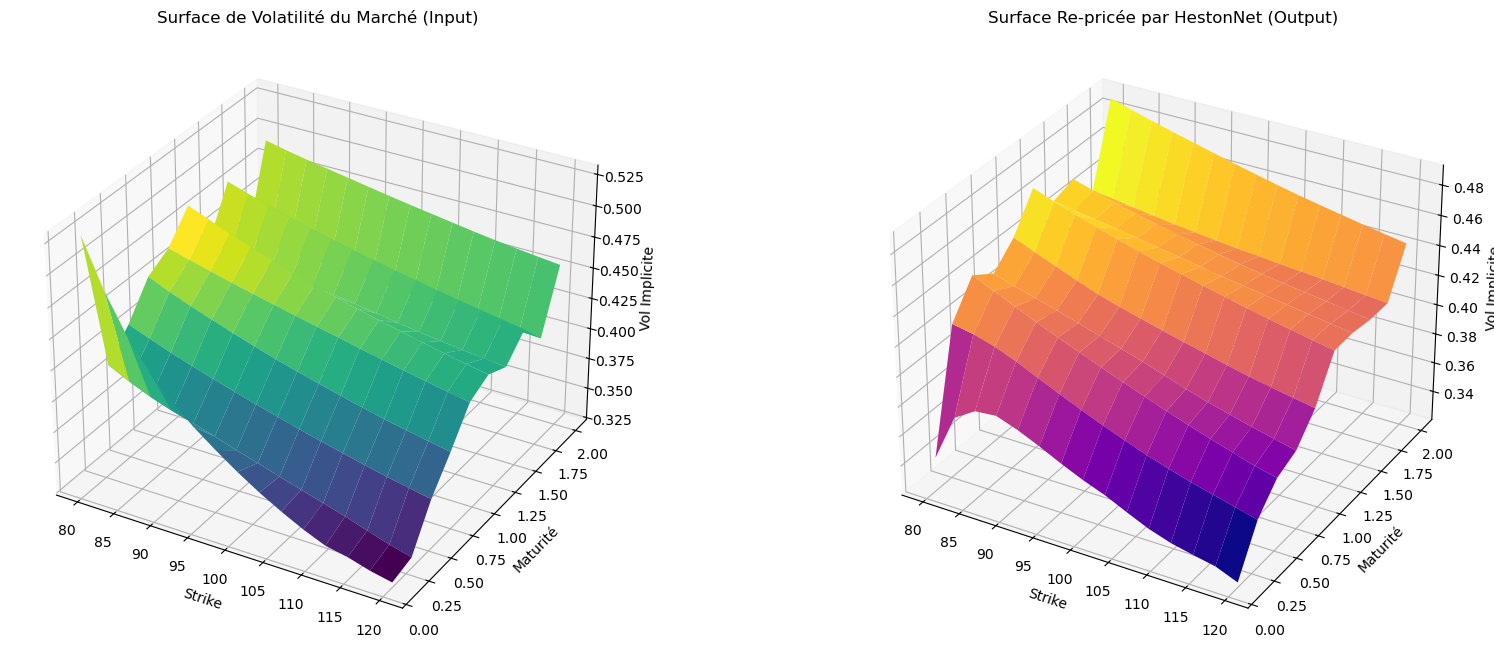

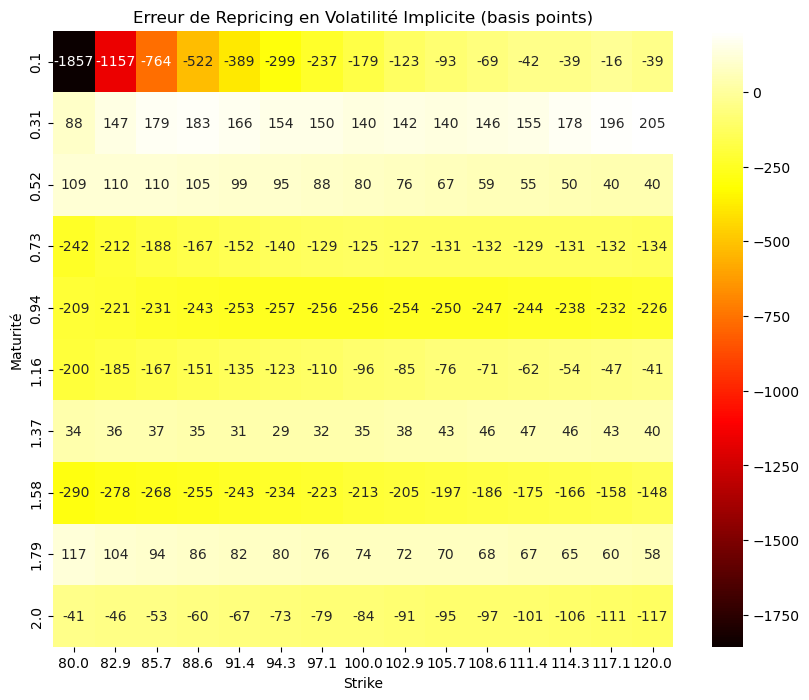

In [43]:
# Choisir un échantillon de test aléatoire
sample_idx = np.random.randint(0, len(X_test))
input_surface_scaled = X_test[sample_idx].reshape(1, -1)
true_params_scaled = y_test[sample_idx]

# Prédiction
start_time = time.time()
predicted_params_scaled = heston_net.predict(input_surface_scaled)
end_time = time.time()

# DÉNORMALISER les résultats pour les rendre lisibles
input_surface = x_scaler.inverse_transform(input_surface_scaled).flatten()
true_params = y_scaler.inverse_transform(true_params_scaled.reshape(1, -1)).flatten()
predicted_params = y_scaler.inverse_transform(predicted_params_scaled).flatten()

# Afficher les paramètres
param_names = ['v0', 'kappa', 'theta', 'gamma', 'rho']
print("\n--- ÉVALUATION VISUELLE DE LA CALIBRATION ---")
print(f"Calibration par HestonNet en {(end_time - start_time)*1000:.2f} ms")
print("--------------------------------------------------")
print(f"{'Paramètre':<10} | {'Vraie valeur':<15} | {'Valeur Prédite':<15}")
print("--------------------------------------------------")
for i, name in enumerate(param_names):
    print(f"{name:<10} | {true_params[i]:<15.4f} | {predicted_params[i]:<15.4f}")
print("--------------------------------------------------")

# Recréer la surface de volatilité avec les paramètres prédits
re_priced_ivs = []
is_surface_valid = True
pbar_eval = tqdm(total=len(maturities), desc="Re-pricing de la surface")
for t in maturities:
    prices = heston_mc_pricer(100.0, strikes, t, 0.01, *predicted_params)
    ivs_t = implied_vol(prices, 100.0, strikes, t, 0.01, flag='c', q=0, return_as='numpy', on_error='ignore')
    if np.any(np.isnan(ivs_t)):
        is_surface_valid = False
        break
    re_priced_ivs.append(ivs_t)
pbar_eval.close()

if not is_surface_valid:
    print("\nAVERTISSEMENT : Les paramètres prédits ont produit une surface de vol invalide.")
else:
    re_priced_surface = np.array(re_priced_ivs).flatten()
    
    # Calcul de l'erreur
    error_bps = (re_priced_surface - input_surface) * 10000
    mae = np.mean(np.abs(error_bps))
    print(f"\nErreur de Repricing Moyenne Absolue : {mae:.2f} basis points")

    # Visualisation 3D
    fig = plt.figure(figsize=(20, 8))
    ax1 = fig.add_subplot(121, projection='3d')
    X_grid, Y_grid = np.meshgrid(strikes, maturities)
    ax1.plot_surface(X_grid, Y_grid, input_surface.reshape(len(maturities), -1), cmap='viridis')
    ax1.set_title("Surface de Volatilité du Marché (Input)")
    ax1.set_xlabel("Strike"); ax1.set_ylabel("Maturité"); ax1.set_zlabel("Vol Implicite")

    ax2 = fig.add_subplot(122, projection='3d')
    ax2.plot_surface(X_grid, Y_grid, re_priced_surface.reshape(len(maturities), -1), cmap='plasma')
    ax2.set_title("Surface Re-pricée par HestonNet (Output)")
    ax2.set_xlabel("Strike"); ax2.set_ylabel("Maturité"); ax2.set_zlabel("Vol Implicite")
    plt.show()

    # Visualisation de l'erreur (Heatmap)
    plt.figure(figsize=(10, 8))
    sns.heatmap(error_bps.reshape(len(maturities), -1), xticklabels=np.round(strikes, 1), yticklabels=np.round(maturities, 2), annot=True, fmt=".0f", cmap="hot")
    plt.title("Erreur de Repricing en Volatilité Implicite (basis points)")
    plt.xlabel("Strike"); plt.ylabel("Maturité")
    plt.show()